In [6]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from tensorflow.keras.datasets import cifar100
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout,Activation,Input, UpSampling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from keras.utils import print_summary, to_categorical, np_utils
from keras.preprocessing.image import ImageDataGenerator
import time
import warnings
warnings.filterwarnings("ignore")

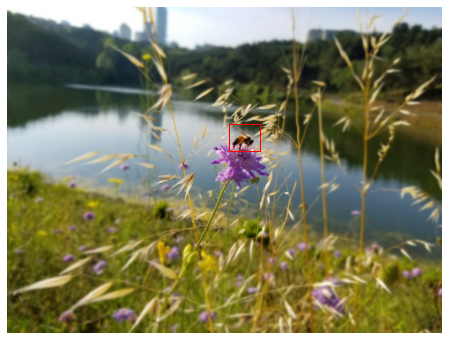

In [7]:
path = "/content/drive/My Drive/"
img = cv.imread(path+'ITU_Golet_Ari.jpeg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
label = scipy.io.loadmat(path+'image_label2.mat')
label = label['label'].tolist()[0]
bee = img[label[1]:label[1]+label[3],label[0]:label[0]+label[2],:]
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(img)
rect = plt.Rectangle((label[0],label[1]),label[3],label[2],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.axis('off')
plt.show()

In [12]:
# batch_size=-1 to get the full dataset in NumPy arrays from the returned tf.Tensor object
# This algorithm may take time.
cifar_train = tfds.load(name="cifar100", split=tfds.Split.TRAIN, batch_size=-1) 
cifar_test = tfds.load(name="cifar100", split=tfds.Split.TEST, batch_size=-1)

# tfds.as_numpy return a generator that yields NumPy array records out of a tf.data.Dataset
cifar_train = tfds.as_numpy(cifar_train) 
cifar_test = tfds.as_numpy(cifar_test)

x_train, y_train = cifar_train["image"], cifar_train["coarse_label"] # seperate the x and y
x_test, y_test = cifar_test["image"], cifar_test["coarse_label"]
  
num_classes = 20
nb_epochs = 10

# (x_train, y_train), (x_test, y_test) = cifar100.load_data()

#Pre-process the data
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

# datagen = ImageDataGenerator(preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))
datagen = ImageDataGenerator()
datagen.fit(x_train)
# datagen.fit(x_train)

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

model = Sequential()
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(.25))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))


model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

t=time.time()
historytemp = model.fit_generator(datagen.flow(x_train, y_train,
                                  batch_size=32),
                                  steps_per_epoch=x_train.shape[0] // 32,
                                  epochs=15,
                                  validation_data=(x_test, y_test))
print('Training time: %s' % (t - time.time()))

Epoch 1/15
1562/1562 [==============================] - 710s 455ms/step - loss: 0.9939 - accuracy: 0.6859 - val_loss: 0.5683 - val_accuracy: 0.8091
Epoch 2/15
1562/1562 [==============================] - 710s 454ms/step - loss: 0.6012 - accuracy: 0.8061 - val_loss: 0.5056 - val_accuracy: 0.8352
Epoch 3/15
1562/1562 [==============================] - 710s 455ms/step - loss: 0.5047 - accuracy: 0.8349 - val_loss: 0.4554 - val_accuracy: 0.8552
Epoch 4/15
1562/1562 [==============================] - 711s 455ms/step - loss: 0.4400 - accuracy: 0.8560 - val_loss: 0.4346 - val_accuracy: 0.8600
Epoch 5/15
1562/1562 [==============================] - 711s 455ms/step - loss: 0.3953 - accuracy: 0.8710 - val_loss: 0.4242 - val_accuracy: 0.8660
Epoch 6/15
1562/1562 [==============================] - 711s 455ms/step - loss: 0.3546 - accuracy: 0.8819 - val_loss: 0.4440 - val_accuracy: 0.8604
Epoch 7/15
1562/1562 [==============================] - 712s 456ms/step - loss: 0.3281 - accuracy: 0.8905 - val_

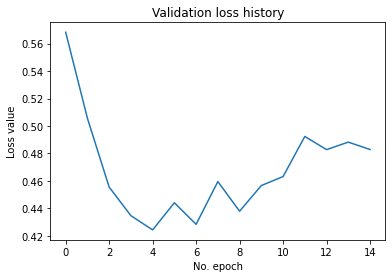

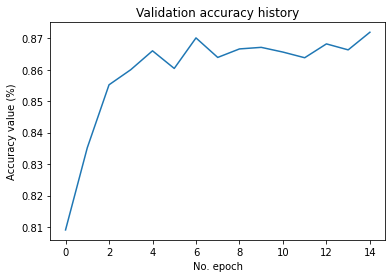

In [13]:
plt.plot(historytemp.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(historytemp.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

In [20]:
path = "/content/drive/My Drive/"
row_size, col_size = 256,256
img = cv.imread(path+'ITU_Golet_Ari.jpeg')
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
img= img[460:530,830:910,:]
img2 = preprocess_input(img)/255.0
img2 = cv.resize(img2,(row_size,col_size))
img2 = np.reshape(img2,[1,row_size,col_size,3])
classes = model.predict_classes(img2)
print(classes)

[10]


Text(0.5, 1.0, 'Estimated Cluster: bowl')

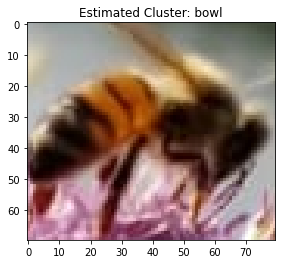

In [21]:
cifar100_tf = tfds.builder("cifar100")
info = cifar100_tf.info
plt.imshow(img)
plt.title("Estimated Cluster: "+info.features['label'].int2str(int(classes)))